In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler , StandardScaler
import pickle

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder


In [6]:
df_filtered = pd.read_csv('df_filtered.csv')

In [39]:
le = LabelEncoder()
df_filtered['Cross Reference Type_encoded'] = le.fit_transform(df_filtered['Cross Reference Type'])

# Display the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [40]:
df_filtered["Cross Reference Type"].value_counts()

Cross Reference Type
D    808455
C    159451
B     36926
A     18360
Name: count, dtype: int64

In [41]:
from sklearn.model_selection import train_test_split
def split_dataframe(df, train_percent=0.8, validate_percent=0.1, test_percent=0.1, random_state=42, stratify_col="Cross Reference Type"):
    assert train_percent + validate_percent + test_percent == 1, "Split percentages must sum to 1."

    # First split: Train and Temp (Validate + Test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(validate_percent + test_percent),
        stratify=df[stratify_col],
        random_state=random_state
    )
    
    # Calculate the proportion of validation and test from the Temp split
    if validate_percent==0:
        return train_df,pd.DataFrame(columns=df.columns), temp_df
    test_size = test_percent / (validate_percent + test_percent)
    
    # Second split: Validate and Test
    validate_df, test_df = train_test_split(
        temp_df,
        test_size=test_size,
        stratify=temp_df[stratify_col],
        random_state=random_state
    )
    
    return train_df, validate_df, test_df

In [42]:
train_df, validate_df, test_df = split_dataframe(df_filtered,validate_percent=0,test_percent=0.2)
print(train_df["Cross Reference Type"].value_counts(normalize=True))
print(validate_df["Cross Reference Type"].value_counts(normalize=True))
print(test_df["Cross Reference Type"].value_counts(normalize=True))

Cross Reference Type
D    0.790130
C    0.155837
B    0.036089
A    0.017944
Name: proportion, dtype: float64
Series([], Name: proportion, dtype: float64)
Cross Reference Type
D    0.790133
C    0.155835
B    0.036088
A    0.017944
Name: proportion, dtype: float64


In [90]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class CustomVectorDataset(Dataset):
    def __init__(self, dataframe, vector1_columns, vector2_columns, target_column, categorical_columns=[]):
        """
        Args:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            vector1_columns (list): List of column names for the first vector.
            vector2_columns (list): List of column names for the second vector.
            target_column (str): The column name for the target value.
            categorical_columns (list): List of column names that are categorical.
        """
        self.dataframe = dataframe.copy()
        self.vector1_columns = vector1_columns
        self.vector2_columns = vector2_columns
        self.target_column = target_column
        self.categorical_columns = categorical_columns
        
        # Label encode categorical columns
        self.label_encoders = {}
        for col in self.categorical_columns:
            le = LabelEncoder()
            self.dataframe[col] = le.fit_transform(self.dataframe[col])
            self.label_encoders[col] = le
        
        # Convert columns to tensors
        self.vector1 = torch.tensor(self.dataframe[vector1_columns].values, dtype=torch.float32)
        self.vector2 = torch.tensor(self.dataframe[vector2_columns].values, dtype=torch.float32)
        self.target = torch.tensor(self.dataframe[target_column].values, dtype=torch.long)  # Ensure targets are LongTensor and 1D

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        vector1 = self.vector1[idx]
        vector2 = self.vector2[idx]
        target = self.target[idx]  # Already a LongTensor and 1D
        return vector1, vector2, target

In [110]:
import torch
import torch.nn as nn

class FullyConnectedClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(FullyConnectedClassifier, self).__init__()
        combined_dim = input_dim * 2  # Concatenated input dimensions

        self.feature_extractor = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, num_classes)
        )

    def forward(self, input1, input2):
        combined = torch.cat((input1, input2), dim=1)
        features = self.feature_extractor(combined)
        out = self.classifier(features)
        return out

In [92]:
columns_1 = ['MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product']
columns_2 = ['MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp']
categorical_columns=['MPN', 'MANUFACTURER','Supplier_Package','MPN_comp',
       'MANUFACTURER_comp','Supplier_Package_comp']

In [113]:
batch_size = 64

In [114]:
torch.manual_seed(42)
dataset_train = CustomVectorDataset(train_df,columns_1,columns_2, 'Cross Reference Type_encoded',categorical_columns=categorical_columns)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
# Test
dataset_test = CustomVectorDataset(test_df, columns_1, columns_2, 'Cross Reference Type_encoded', categorical_columns=categorical_columns)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
# Validation
# dataset_validate = CustomVectorDataset(validate_df, columns_1, columns_2, 'Closeness', categorical_columns=categorical_columns)
# dataloader_validate = DataLoader(dataset_validate, batch_size=batch_size, shuffle=False)

In [115]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [116]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df["Cross Reference Type_encoded"]), y=train_df["Cross Reference Type_encoded"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [117]:
np.unique(train_df["Cross Reference Type_encoded"])

array([0, 1, 2, 3])

In [118]:
class_weights

tensor([13.9323,  6.9273,  1.6042,  0.3164], device='cuda:0')

In [119]:
# Inspect a batch from the training DataLoader
for batch in dataloader_train:
    input1, input2, targets = batch
    print("Input1 shape:", input1.shape)   # Expected: [batch_size, input_dim]
    print("Input2 shape:", input2.shape)   # Expected: [batch_size, input_dim]
    print("Targets shape:", targets.shape) # Expected: [batch_size]
    print("Targets dtype:", targets.dtype) # Expected: torch.long
    break

Input1 shape: torch.Size([64, 8])
Input2 shape: torch.Size([64, 8])
Targets shape: torch.Size([64])
Targets dtype: torch.int64


In [120]:
from tqdm import tqdm
input_dim = len(columns_1)
model = FullyConnectedClassifier(input_dim).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.1, patience=3, 
                                                 verbose=True)

c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [128]:
num_epochs = 12
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # -----------------------------
    # 5.1. Training Phase
    # -----------------------------
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for vec1, vec2, target in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(vec1, vec2)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * vec1.size(0)  # Accumulate loss
        
        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    
    epoch_train_loss = running_loss / len(dataloader_train.dataset)
    train_loss_history.append(epoch_train_loss)
    
    epoch_train_accuracy = correct_train / total_train
    train_accuracy_history.append(epoch_train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
    
    # -----------------------------
    # 5.2. Validation Phase
    # -----------------------------
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for vec1, vec2, target in tqdm(dataloader_test, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
            
            output = model(vec1, vec2)
            loss = criterion(output, target)
            val_running_loss += loss.item() * vec1.size(0)  # Accumulate loss
            
            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
    
    epoch_val_loss = val_running_loss / len(dataloader_test.dataset)
    val_loss_history.append(epoch_val_loss)
    
    epoch_val_accuracy = correct_val / total_val
    val_accuracy_history.append(epoch_val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")
    
    # -----------------------------
    # 5.3. Step the Scheduler
    # -----------------------------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "DL-classifier.pth")
        print(f"  -> Best model saved with Validation Loss: {best_val_loss:.4f}")
    
    scheduler.step(epoch_val_loss)

Epoch 1/12 - Training: 100%|██████████| 12790/12790 [01:35<00:00, 134.57it/s]


Epoch [1/12], Training Loss: 0.5595, Training Accuracy: 0.8116


Epoch 1/12 - Validation: 100%|██████████| 3198/3198 [00:10<00:00, 293.00it/s]


Epoch [1/12], Validation Loss: 2.8146, Validation Accuracy: 0.6047
  -> Best model saved with Validation Loss: 2.8146


Epoch 2/12 - Training: 100%|██████████| 12790/12790 [01:34<00:00, 135.89it/s]


Epoch [2/12], Training Loss: 0.5595, Training Accuracy: 0.8116


Epoch 2/12 - Validation: 100%|██████████| 3198/3198 [00:10<00:00, 291.89it/s]


Epoch [2/12], Validation Loss: 2.7910, Validation Accuracy: 0.6039
  -> Best model saved with Validation Loss: 2.7910


Epoch 3/12 - Training: 100%|██████████| 12790/12790 [01:35<00:00, 133.31it/s]


Epoch [3/12], Training Loss: 0.5593, Training Accuracy: 0.8113


Epoch 3/12 - Validation: 100%|██████████| 3198/3198 [00:11<00:00, 285.23it/s]


Epoch [3/12], Validation Loss: 2.7822, Validation Accuracy: 0.6011
  -> Best model saved with Validation Loss: 2.7822


Epoch 4/12 - Training: 100%|██████████| 12790/12790 [01:43<00:00, 123.83it/s]


Epoch [4/12], Training Loss: 0.5594, Training Accuracy: 0.8120


Epoch 4/12 - Validation: 100%|██████████| 3198/3198 [00:10<00:00, 300.77it/s]


Epoch [4/12], Validation Loss: 2.7088, Validation Accuracy: 0.5981
  -> Best model saved with Validation Loss: 2.7088


Epoch 5/12 - Training: 100%|██████████| 12790/12790 [01:36<00:00, 132.47it/s]


Epoch [5/12], Training Loss: 0.5589, Training Accuracy: 0.8117


Epoch 5/12 - Validation: 100%|██████████| 3198/3198 [00:10<00:00, 302.52it/s]


Epoch [5/12], Validation Loss: 2.7425, Validation Accuracy: 0.5950


Epoch 6/12 - Training: 100%|██████████| 12790/12790 [01:37<00:00, 130.54it/s]


Epoch [6/12], Training Loss: 0.5595, Training Accuracy: 0.8116


Epoch 6/12 - Validation: 100%|██████████| 3198/3198 [00:12<00:00, 259.71it/s]


Epoch [6/12], Validation Loss: 2.7124, Validation Accuracy: 0.5924


Epoch 7/12 - Training: 100%|██████████| 12790/12790 [01:39<00:00, 129.05it/s]


Epoch [7/12], Training Loss: 0.5594, Training Accuracy: 0.8117


Epoch 7/12 - Validation: 100%|██████████| 3198/3198 [00:09<00:00, 335.82it/s]


Epoch [7/12], Validation Loss: 2.7470, Validation Accuracy: 0.5955


Epoch 8/12 - Training: 100%|██████████| 12790/12790 [01:37<00:00, 130.86it/s]


Epoch [8/12], Training Loss: 0.5596, Training Accuracy: 0.8117


Epoch 8/12 - Validation: 100%|██████████| 3198/3198 [00:12<00:00, 263.95it/s]


Epoch [8/12], Validation Loss: 2.8062, Validation Accuracy: 0.6034


Epoch 9/12 - Training: 100%|██████████| 12790/12790 [01:37<00:00, 131.78it/s]


Epoch [9/12], Training Loss: 0.5593, Training Accuracy: 0.8112


Epoch 9/12 - Validation: 100%|██████████| 3198/3198 [00:10<00:00, 316.20it/s]


Epoch [9/12], Validation Loss: 2.7303, Validation Accuracy: 0.5994


Epoch 10/12 - Training: 100%|██████████| 12790/12790 [01:42<00:00, 125.32it/s]


Epoch [10/12], Training Loss: 0.5596, Training Accuracy: 0.8117


Epoch 10/12 - Validation: 100%|██████████| 3198/3198 [00:11<00:00, 274.17it/s]


Epoch [10/12], Validation Loss: 2.7896, Validation Accuracy: 0.6026


Epoch 11/12 - Training: 100%|██████████| 12790/12790 [01:33<00:00, 136.77it/s]


Epoch [11/12], Training Loss: 0.5586, Training Accuracy: 0.8118


Epoch 11/12 - Validation: 100%|██████████| 3198/3198 [00:12<00:00, 263.08it/s]


Epoch [11/12], Validation Loss: 2.7697, Validation Accuracy: 0.6001


Epoch 12/12 - Training: 100%|██████████| 12790/12790 [01:31<00:00, 139.52it/s]


Epoch [12/12], Training Loss: 0.5594, Training Accuracy: 0.8115


Epoch 12/12 - Validation: 100%|██████████| 3198/3198 [00:08<00:00, 363.73it/s]

Epoch [12/12], Validation Loss: 2.8024, Validation Accuracy: 0.5985


In [122]:
train_hist_loss= []
val_hist_loss = []
train_hist_acc = []
val_hist_acc = []


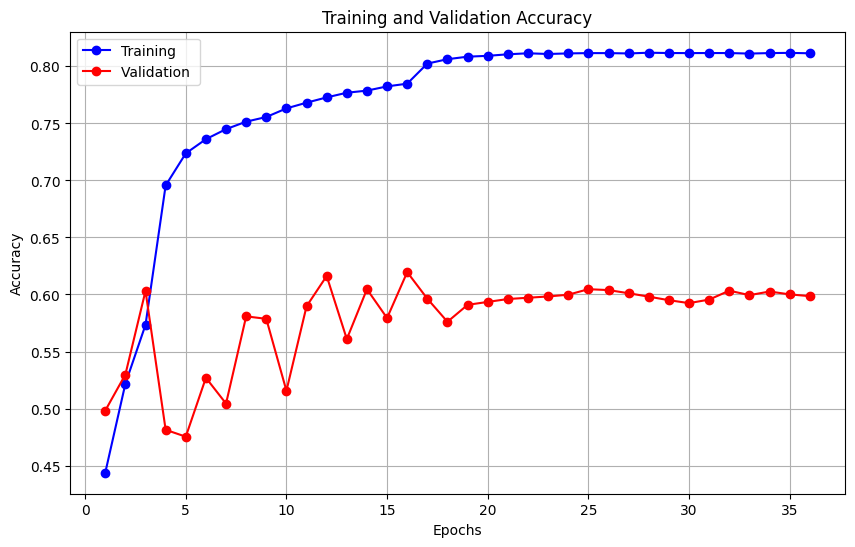

In [129]:


train_hist_loss.extend(train_loss_history)
val_hist_loss.extend(val_loss_history)
train_hist_acc.extend(train_accuracy_history)
val_hist_acc.extend(val_accuracy_history)

epochs = range(1,len(train_hist_loss)+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_hist_acc, 'bo-', label='Training ')
plt.plot(epochs, val_hist_acc, 'ro-', label='Validation ')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

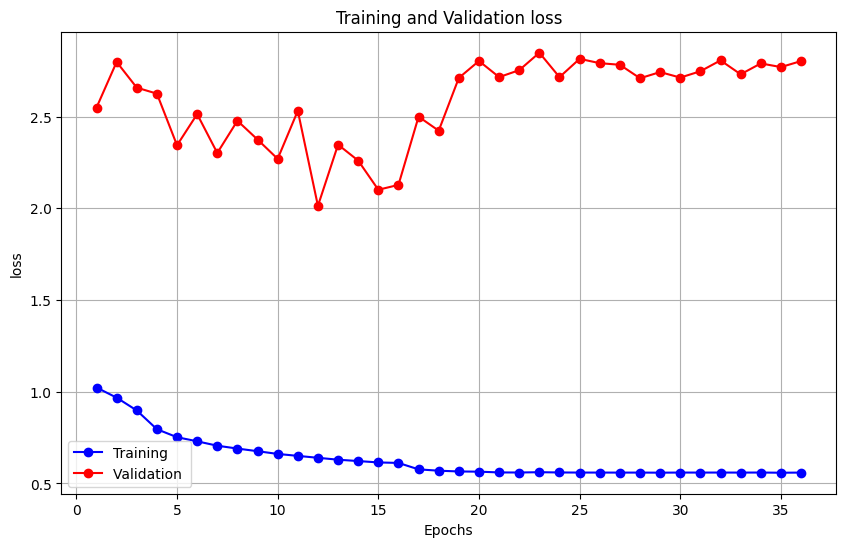

: 

In [ ]:
epochs = range(1,len(train_hist_loss)+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_hist_loss, 'bo-', label='Training ')
plt.plot(epochs, val_hist_loss, 'ro-', label='Validation ')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

Evaluating on Test Set: 100%|██████████| 6395/6395 [00:15<00:00, 412.31it/s]


Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.03      0.28      0.05      3672
           B       0.04      0.00      0.00      7385
           C       0.16      0.08      0.10     31890
           D       0.82      0.76      0.79    161692

    accuracy                           0.62    204639
   macro avg       0.26      0.28      0.24    204639
weighted avg       0.68      0.62      0.64    204639



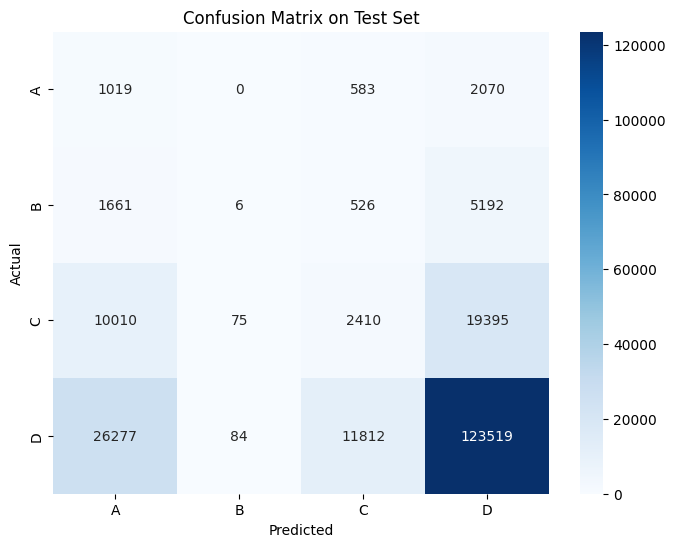

In [107]:
from sklearn.metrics import classification_report, confusion_matrix

# model.load_state_dict(torch.load(best_model_path))
model.to(device)

model.eval()
all_test_targets = []
all_test_predictions = []

with torch.no_grad():
    for vec1, vec2, target in tqdm(dataloader_test, desc="Evaluating on Test Set"):
        vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
        output = model(vec1, vec2)
        _, predicted = torch.max(output, 1)
        all_test_targets.extend(target.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

# Generate Classification Report
test_class_report = classification_report(all_test_targets, all_test_predictions, target_names=le.classes_, zero_division=0)
print("Test Set Classification Report:")
print(test_class_report)

# Generate Confusion Matrix
conf_mat = confusion_matrix(all_test_targets, all_test_predictions, labels=range(len(le.classes_)))
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()